In [2]:
import torch
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
def make_It(path='linear', gamma = None, gamma_dot = None, gg_dot = None):
    """gamma function must be specified if using the trigonometric interpolant"""

    if path == 'linear':

        a      = lambda t: (1-t)
        adot   = lambda t: -1.0
        b      = lambda t: t
        bdot   = lambda t: 1.0
        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'trig':
        if gamma == None:
            raise TypeError("Gamma function must be provided for trigonometric interpolant!")
        a    = lambda t: torch.sqrt(1 - gamma(t)**2)*torch.cos(0.5*math.pi*t)
        b    = lambda t: torch.sqrt(1 - gamma(t)**2)*torch.sin(0.5*math.pi*t)
        adot = lambda t: -gg_dot(t)/torch.sqrt(1 - gamma(t)**2)*torch.cos(0.5*math.pi*t) \
                                - 0.5*math.pi*torch.sqrt(1 - gamma(t)**2)*torch.sin(0.5*math.pi*t)
        bdot = lambda t: -gg_dot(t)/torch.sqrt(1 - gamma(t)**2)*torch.sin(0.5*math.pi*t) \
                                + 0.5*math.pi*torch.sqrt(1 - gamma(t)**2)*torch.cos(0.5*math.pi*t)

        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'encoding-decoding':

        a    = lambda t: torch.where(t <= 0.5, torch.cos(math.pi*t)**2, torch.tensor(0.))
        adot = lambda t: torch.where(t <= 0.5, -2*math.pi*torch.cos(math.pi*t)*torch.sin(math.pi*t), torch.tensor(0.))
        b    = lambda t: torch.where(t > 0.5,  torch.cos(math.pi*t)**2, 0.)
        bdot = lambda t: torch.where(t > 0.5,  -2*math.pi*torch.cos(math.pi*t)*torch.sin(math.pi*t), torch.tensor(0.))
        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'one-sided-linear':

        a      = lambda t: (1-t)
        adot   = lambda t: -1.0
        b      = lambda t: t
        bdot   = lambda t: 1.0

        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'one-sided-trig':

        a      = lambda t: torch.cos(0.5*math.pi*t)
        adot   = lambda t: -0.5*math.pi*torch.sin(0.5*math.pi*t)
        b      = lambda t: torch.sin(0.5*math.pi*t)
        bdot   = lambda t: 0.5*math.pi*torch.cos(0.5*math.pi*t)


        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'mirror':
        if gamma == None:
            raise TypeError("Gamma function must be provided for mirror interpolant!")

        a     = lambda t: gamma(t)
        adot  = lambda t: gamma_dot(t)
        b     = lambda t: torch.tensor(1.0)
        bdot  = lambda t: torch.tensor(0.0)

        It    = lambda t, x0, x1: b(t)*x1 + a(t)*x0
        dtIt  = lambda t, x0, x1: adot(t)*x0

    elif path == 'custom':
        return None, None, None

    else:
        raise NotImplementedError("The interpolant you specified is not implemented.")


    return It, dtIt, (a, adot, b, bdot)


def make_gamma(gamma_type = 'brownian', aval = None):
    """
    returns callable functions for gamma, gamma_dot,
    and gamma(t)*gamma_dot(t) to avoid numerical divide by 0s,
    e.g. if one is using the brownian (default) gamma.
    """
    if gamma_type == 'brownian':
        gamma = lambda t: torch.sqrt(t*(1-t))
        gamma_dot = lambda t: (1/(2*torch.sqrt(t*(1-t)))) * (1 -2*t)
        gg_dot = lambda t: (1/2)*(1-2*t)

    elif gamma_type == 'a-brownian':
        gamma = lambda t: torch.sqrt(a*t*(1-t))
        gamma_dot = lambda t: (1/(2*torch.sqrt(a*t*(1-t)))) * a*(1 -2*t)
        gg_dot = lambda t: (a/2)*(1-2*t)

    elif gamma_type == 'zero':
        gamma = gamma_dot = gg_dot = lambda t: torch.zeros_like(t)

    elif gamma_type == 'bsquared':
        gamma = lambda t: t*(1-t)
        gamma_dot = lambda t: 1 -2*t
        gg_dot = lambda t: gamma(t)*gamma_dot(t)

    elif gamma_type == 'sinesquared':
        gamma = lambda t: torch.sin(math.pi * t)**2
        gamma_dot = lambda t: 2*math.pi*torch.sin(math.pi * t)*torch.cos(math.pi*t)
        gg_dot = lambda t: gamma(t)*gamma_dot(t)

    elif gamma_type == 'sigmoid':
        f = torch.tensor(10.0)
        gamma = lambda t: torch.sigmoid(f*(t-(1/2)) + 1) - torch.sigmoid(f*(t-(1/2)) - 1) - torch.sigmoid((-f/2) + 1) + torch.sigmoid((-f/2) - 1)
        gamma_dot = lambda t: (-f)*( 1 - torch.sigmoid(-1 + f*(t - (1/2))) )*torch.sigmoid(-1 + f*(t - (1/2)))  + f*(1 - torch.sigmoid(1 + f*(t - (1/2)))  )*torch.sigmoid(1 + f*(t - (1/2)))
        gg_dot = lambda t: gamma(t)*gamma_dot(t)

    elif gamma_type == None:
        gamma     = lambda t: torch.zeros(1) ### no gamma
        gamma_dot = lambda t: torch.zeros(1) ### no gamma
        gg_dot    = lambda t: torch.zeros(1) ### no gamma

    else:
        raise NotImplementedError("The gamma you specified is not implemented.")


    return gamma, gamma_dot, gg_dot

In [1]:
!pip install torchdiffeq

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
class Interpolant(torch.nn.Module):
    """
    Class for all things interpoalnt $x_t = I_t(x_0, x_1) + \gamma(t)z.
    If path is one-sided, then interpolant constructs x_t = a(t) x_0 + b(t) x_1 with x_0 ~ N(0,1).

    path: str,    what type of interpolant to use, e.g. 'linear' for linear interpolant. see fabrics for options
    gamma_type:   what type of gamma function to use, e.g. 'brownian' for $\gamma(t) = \sqrt{t(1-t)}
    """
    def __init__(self, path, gamma_type,gamma= None,gamma_dot = None,gg_dot= None,It = None, dtIt= None):
        super(Interpolant, self).__init__()


        self.path = path
        if gamma == None:
            if self.path == 'one-sided-linear' or self.path == 'one-sided-trig':
              gamma_type = None

            self.gamma, self.gamma_dot, self.gg_dot = make_gamma(gamma_type=gamma_type)

        else:
            self.gamma, self.gamma_dot, self.gg_dot = gamma, gamma_dot, gg_dot

        if self.path == 'custom':
            print('Assuming interpolant was passed in directly...')
            self.It = It
            self.dtIt = dtIt
            assert self.It != None
            assert self.dtIt != None


        self.It, self.dtIt, ab = make_It(path, self.gamma, self.gamma_dot, self.gg_dot)
        self.a, self.adot, self.b, self.bdot = ab[0], ab[1], ab[2], ab[3]


    def calc_xt(self, t, x0, x1):
        if self.path =='one-sided-linear' or self.path == 'mirror' or self.path=='one-sided-trig':
            return self.It(t, x0, x1)
        else:
            z = torch.randn(x0.shape).to(t)
            return self.It(t, x0, x1) + self.gamma(t)*z, z


In [4]:
def loss_per_sample_b(b, x0, x1, t, interpolant):
    """Compute the (variance-reduced) loss on an individual sample via antithetic sampling."""

    xt, z = interpolant.calc_xt(t, x0, x1)
    xt = xt.unsqueeze(0)
    dtIt        = interpolant.dtIt(t, x0, x1)
    gamma_dot   = interpolant.gamma_dot(t)
    bt         = b(xt, t)
    loss        = 0.5*torch.sum(bt**2) - torch.sum((dtIt + gamma_dot*z) * bt)
    return loss

def loss_per_sample_b_one_sided(b, x0, x1, t, interpolant):
    """Compute the (variance-reduced) loss on an individual sample via antithetic sampling."""

    xt = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    dtIt        = interpolant.dtIt(t, x0, x1)
    gamma_dot   = interpolant.gamma_dot(t)
    bt         = b(xt, t)
    loss        = 0.5*torch.sum(bt**2) - torch.sum((dtIt) * bt)
    return loss

def loss_per_sample_s(
    s, x0, x1, t, interpolant
):
    """Compute the (variance-reduced) loss on an individual sample via antithetic sampling."""
    xt ,z = interpolant.calc_xt(t, x0, x1)
    xt ,t = xt.unsqueeze(0), t.unsqueeze(0)
    st = s(xt, t)
    loss = 0.5 * torch.sum(st**2) + (1 / interpolant.gamma(t)) * torch.sum(st * z)
    return loss

def loss_per_sample_eta(
    eta, x0, x1, t, interpolant
):
    """Compute the loss on an individual sample via antithetic sampling."""
    xt, z = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    eta_val = eta(xt, t)
    return 0.5 * torch.sum(eta_val**2) + torch.sum(eta_val * z)

def loss_per_sample_v(
    v, x0, x1, t, interpolant
):
    """Compute the loss on an individual sample via antithetic sampling."""
    xt, z = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    dtIt = interpolant.dtIt(t, x0, x1)
    v_val = v(xt, t)
    return 0.5 * torch.sum(v_val**2) - torch.sum(dtIt * v_val)

def loss_per_sample_one_sided_v(
    v, x0, x1, t, interpolant
):
    """Compute the loss on an individual sample."""
    xt = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    dtIt = interpolant.dtIt(t, x0, x1)
    vt = v(xt, t)
    loss = 0.5 * torch.sum(vt**2) - torch.sum(dtIt * vt)
    return loss

def loss_per_sample_one_sided_s(
    s, x0, x1, t, interpolant
):
    """Compute the loss on an individual sample via antithetic samples for x_t = sqrt(1-t)z + sqrt(t) x1 where z=x0."""
    xt, z = interpolant.calc_xt(t, x0, x1)
    xtt = xt.unsqueeze(0), t.unsqueeze(0)
    st = s(xt, t)
    alpha = interpolant.a(t)
    loss = 0.5 * torch.sum(st**2) + (1 / alpha) * torch.sum(st * x0)
    return loss

def loss_per_sample_one_sided_eta(
    eta, x0, x1, t, interpolant
):
    """Compute the loss on an individual sample via samples for x_t = alpha(t)z + beta(t) x1 where z=x0."""
    xt = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    etat = eta(xt, t)
    loss = 0.5 * torch.sum(etat**2) + torch.sum(etat * x0)
    return loss

def loss_per_sample_mirror(
    s, x0, x1, t, interpolant
):
    """Compute the loss on an individual sample via antithetic sampling."""
    xt = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    dtIt = interpolant.dtIt(t, x0, x1)
    st = s(xt, t)
    loss = 0.5 * torch.sum(st**2) + (1 / interpolant.gamma(t)) * torch.sum(st * x0)
    return loss


def make_loss(loss, bvseta, x0,x1, t, interpolant):
    """Convert a sample loss into a batched loss."""
    ## Share the batch dimension i for x0, x1, t
    in_dims_set = (None, 0, 0, 0, None)
    batched_loss = torch.vmap(loss, in_dims=in_dims_set, randomness='different')
    loss_val = batched_loss(bvseta, x0, x1, t, interpolant)
    loss_val = loss_val.mean()
    return loss_val





In [11]:
class SDEIntegrator(torch.nn.Module):
    def __init__(self, b, s = None,eps=torch.tensor(0),interpolant=None,n_save=4,start_end = (0, 1), n_step = 100):
        super(SDEIntegrator, self).__init__()
        self.b =b
        self.s=s
        self.eps = eps
        self.n_save = n_save
        self.n_step = n_step
        self.start_end = start_end
        self.start, self.end = self.start_end
        self.ts = torch.linspace(self.start, self.end, self.n_step)
        self.dt = self.ts[1] - self.ts[0]
        self.interpolant = interpolant
        if self.s is None or self.eps == 0:
            self.bf = self.b
        else:
            self.bf = lambda x, t: self.b(x, t) + self.eps * self.s(x, t)




    def step_forward_heun(self, x: torch.tensor, t: torch.tensor) -> torch.tensor:
        """Heun Step -- see https://arxiv.org/pdf/2206.00364.pdf, Alg. 2"""
        dW = torch.sqrt(self.dt) * torch.randn_like(x)
        xhat = x + torch.sqrt(2 * self.eps) * dW
        K1 = self.bf(xhat, t + self.dt)
        xp = xhat + self.dt * K1
        K2 = self.bf(xp, t + self.dt)
        return xhat + 0.5 * self.dt * (K1 + K2)

    def step_forward(self, x: torch.tensor, t: torch.tensor) -> torch.tensor:
        """Euler-Maruyama."""
        dW = torch.sqrt(self.dt) * torch.randn_like(x)
        return x + self.bf(x, t) * self.dt + torch.sqrt(2 * self.eps) * dW

    def rollout_forward(self, init: torch.tensor, method: str = 'heun') -> torch.tensor:
        """Solve the forward-time SDE to generate a batch of samples."""
        save_every = int(self.n_step / self.n_save)
        xs = torch.zeros((self.n_save, *init.shape)).to(init.device)
        x = init
        self.dt = self.dt.to(init.device)

        save_counter = 0

        for ii, t in enumerate(self.ts[:-1]):
            t = t.to(init.device).unsqueeze(0)
            if method == 'heun':
                x = self.step_forward_heun(x, t)
            else:
                x = self.step_forward(x, t)

            if (ii + 1) % save_every == 0:
                xs[save_counter] = x
                save_counter += 1

        xs[save_counter] = x

        return xs


class SFromEta(torch.nn.Module):
    """Class for turning a noise model into a score model."""
    def __init__(
        self,
        eta,
        gamma,
    ) -> None:
        super(SFromEta, self).__init__()
        self.eta = eta
        self.gamma = gamma

    def forward(self, x, t):
        val = (self.eta(x,t) / self.gamma(t))
        return val

def grab(var):
    return var.detach().cpu().numpy()

In [6]:
def compute_div(f,x,t):
    """Compute the divergence of f(x,t) with respect to x, assuming that x is batched. Assumes data is [bs, d]"""
    bs = x.shape[0]
    with torch.set_grad_enabled(True):
        x.requires_grad_(True)
        t.requires_grad_(True)
        f_val = f(x, t)
        divergence = 0.0
        for i in range(x.shape[1]):
            divergence += \
                    torch.autograd.grad(
                            f_val[:, i].sum(), x, create_graph=True
                        )[0][:, i]

    return divergence.view(bs)


class PFlowRHS(torch.nn.Module):
    def __init__(self, b, interpolant, sample_only=False):
        super(PFlowRHS, self).__init__()
        self.b = b
        self.interpolant = interpolant
        self.sample_only = sample_only


    def setup_rhs(self):
        def rhs(x: torch.tensor, t: torch.tensor):
            self.b.to(x)

            t = t.unsqueeze(0)
            return self.b(x,t)

        self.rhs = rhs


    def forward(self, t, states):
        x = states[0]
        if self.sample_only:
            return (self.rhs(x, t), torch.zeros(x.shape[0]).to(x))
        else:
            return (self.rhs(x, t), -compute_div(self.rhs, x, t))

    def reverse(self, t: torch.tensor, states):
        x = states[0]
        if self.sample_only:
            return (-self.rhs(x, t), torch.zeros(x.shape[0]).to(x))
        else:
            return (-self.rhs(x, t), compute_div(self.rhs, x, t))



class MirrorPFlowRHS(torch.nn.Module):
    def __init__(self, s, interpolant, sample_only=False):
        super(MirrorPFlowRHS, self).__init__()
        self.s = s
        self.interpolant = interpolant
        self.sample_only = sample_only


    def setup_rhs(self):
        def rhs(x: torch.tensor, t: torch.tensor):
            # tx = net_inp(t, x)
            self.s.to(x)

            t = t.unsqueeze(0)
            return self.interpolant.gg_dot(t)*self.s(x,t)

        self.rhs = rhs


    def forward(self, t, states):
        x = states[0]
        if self.sample_only:
            return (self.rhs(x, t), torch.zeros(x.shape[0]).to(x))
        else:
            return (self.rhs(x, t), -compute_div(self.rhs, x, t))

    def reverse(self, t, states):
        x = states[0]
        if self.sample_only:
            return (-self.rhs(x, t), torch.zeros(x.shape[0]).to(x))
        else:
            return (-self.rhs(x, t), compute_div(self.rhs, x, t))

from dataclasses import dataclass
Velocity = torch.nn.Module

@dataclass
class PFlowIntegrator:
    b: Velocity
    method: str
    interpolant: Interpolant
    start_end: tuple = (0.0, 1.0)
    n_step: int = 5
    atol: torch.tensor = 1e-5
    rtol: torch.tensor = 1e-5
    sample_only: bool  = False
    mirror:      bool  = False


    def __post_init__(self) -> None:
        if self.mirror:
            self.rhs = MirrorPFlowRHS(s=self.b, interpolant=self.interpolant, sample_only=self.sample_only)
        else:
            self.rhs = PFlowRHS(b=self.b, interpolant=self.interpolant, sample_only=self.sample_only)
        self.rhs.setup_rhs()

        self.start, self.end = self.start_end[0], self.start_end[1]


    def rollout(self, x0, reverse=False):
        if reverse:
            integration_times = torch.linspace(self.end, self.start, self.n_step).to(x0)
        else:
            integration_times = torch.linspace(self.start, self.end, self.n_step).to(x0)
        dlogp = torch.zeros(x0.shape[0]).to(x0)

        state = odeint(
            self.rhs,
            (x0, dlogp),
            integration_times,
            method=self.method,
            atol=[self.atol, self.atol],
            rtol=[self.rtol, self.rtol]
        )

        x, dlogp = state
        return x, dlogp


def grab(var):
    return var.detach().cpu().numpy()

### One sided

On part d'une normale pour la



two sided

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]

class UnetModel(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""
    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256):
        super().__init__()
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim), nn.Linear(embed_dim, embed_dim))
        self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, padding=1, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 3, 3, stride=1)
        self.act = lambda x: x * torch.sigmoid(x)

    def forward(self, x, t):
        embed = self.act(self.embed(t))
        h1 = self.conv1(x)
        h1 = h1 + self.dense1(embed).expand_as(h1)
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 = h2 + self.dense2(embed).expand_as(h2)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 = h3 + self.dense3(embed).expand_as(h3)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 = h4 + self.dense4(embed).expand_as(h4)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)
        h = self.tconv4(h4)
        h = h + self.dense5(embed).expand_as(h)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h = h + self.dense6(embed).expand_as(h)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h = h + self.dense7(embed).expand_as(h)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))
        return h
class FullyConnectedModel(nn.Module):
    def __init__(self, input_dim , hidden_dims, output_dim, time_embed_dim):
        super(FullyConnectedModel, self).__init__()
        # Multiply time_embed_dim by input_dim to match the flattened x shape
        self.time_embed = nn.Linear(1, time_embed_dim * input_dim)
        layers = []
        # Adjust prev_dim to account for the change in time embedding
        prev_dim = input_dim + time_embed_dim * input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x, t):
        t_embed = self.time_embed(t.unsqueeze(-1))
        # Ensure 'x' and 't_embed' have compatible shapes for concatenation
        x = x.view(x.size(0), -1)
        x = torch.cat([x, t_embed], dim=-1)
        return self.network(x)





In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.dense(x)[..., None, None]


class UnetModel(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""
    def __init__(self, color_channels = 3, channels=[32, 64, 128, 256], embed_dim=256):
        super().__init__()
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
                                   nn.Linear(embed_dim, embed_dim))
        self.act = lambda x: x * torch.sigmoid(x)

        # Encoding layers
        self.conv1 = nn.Conv2d(color_channels, channels[0], 3, stride=1, padding=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], color_channels, 3, stride=1, padding=1)

    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))

        # Encoding path
        h1 = self.conv1(x)
        h1 += self.dense1(embed)
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)

        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)

        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)

        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)

        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)

        h = self.tconv1(torch.cat([h, h1], dim=1))

        return h


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15855465.93it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 484345.16it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3895043.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4257101.40it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



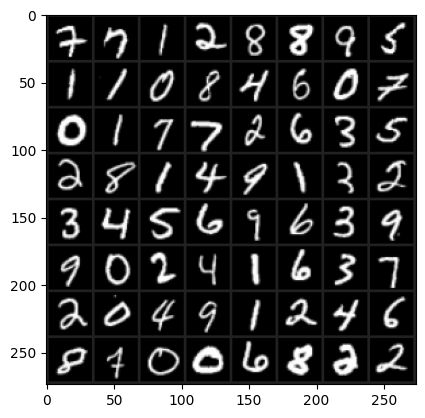

Labels: 7 7 1 2 8 8 9 5


In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Définir les transformations des données pour MNIST
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),  # Convertit les images PIL en tenseurs PyTorch
    transforms.Normalize((0.1307,), (0.3081,))  # Normalisation basée sur les statistiques MNIST
])

# Télécharger et charger le dataset MNIST pour l'entraînement
train_dataset = torchvision.datasets.MNIST(
    root='./data',  # Dossier où les données seront téléchargées
    train=True,  # Charger le jeu de données d'entraînement
    download=True,  # Télécharger les données si elles ne sont pas déjà présentes
    transform=transform  # Appliquer les transformations
)

# Créer le DataLoader pour l'entraînement
train_loader = DataLoader(
    train_dataset,
    batch_size=64,  # Taille des lots
    shuffle=True,  # Mélanger les données
    num_workers=2  # Nombre de sous-processus pour le chargement des données
)

# Fonction pour afficher les images
def imshow(img):
    img = img * 0.3081 + 0.1307  # Dé-normalisation pour les images en niveaux de gris
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transposer les dimensions pour l'affichage avec Matplotlib
    plt.show()

# Obtenir un lot de données d'entraînement
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Afficher les images
imshow(torchvision.utils.make_grid(images))
print('Labels:', ' '.join(str(labels[j].item()) for j in range(8)))  # Afficher les étiquettes correspondantes


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




base_lr = 2e-4
bs = 64

epochs = 50
path = 'one-sided-linear'
interpolant  = Interpolant(path=path, gamma_type='')

b = UnetModel(color_channels = 1).to(device)
eta = UnetModel(color_channels = 1).to(device)

opt_b     = torch.optim.Adam(  b.parameters(), lr=base_lr)
opt_eta   = torch.optim.Adam(eta.parameters(), lr=base_lr)
sched_b   = torch.optim.lr_scheduler.StepLR(optimizer=  opt_b, step_size=1500, gamma=0.4)
sched_eta = torch.optim.lr_scheduler.StepLR(optimizer=opt_eta, step_size=1500, gamma=0.4)


epochs=50
for epoch in range(epochs):
    b.train()
    eta.train()
    for x1, label in train_loader:
        x1 = x1.to(device)
        x0 = torch.randn_like(x1).to(device)
        ts  = torch.rand(size=(x1.shape[0],)).to(device)
        loss_b = make_loss(loss_per_sample_b_one_sided, b,  x0, x1, ts, interpolant)
        loss_eta = make_loss(loss_per_sample_one_sided_eta, eta, x0, x1, ts, interpolant)
        loss = loss_b + loss_eta
        opt_b.zero_grad()
        opt_eta.zero_grad()
        loss_b.backward()
        loss_eta.backward()
        opt_b.step()
        opt_eta.step()
        sched_b.step()
        sched_eta.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')





Epoch 1/50, Loss: -1191.2119140625
Epoch 2/50, Loss: -1256.9205322265625
Epoch 3/50, Loss: -1249.930419921875
Epoch 4/50, Loss: -1237.9661865234375
Epoch 5/50, Loss: -1372.60009765625
Epoch 6/50, Loss: -1264.0950927734375
Epoch 7/50, Loss: -1255.0069580078125
Epoch 8/50, Loss: -1284.17333984375
Epoch 9/50, Loss: -1253.72802734375
Epoch 10/50, Loss: -1300.1932373046875
Epoch 11/50, Loss: -1239.927001953125
Epoch 12/50, Loss: -1280.549560546875
Epoch 13/50, Loss: -1227.27294921875
Epoch 14/50, Loss: -1318.870361328125
Epoch 15/50, Loss: -1254.120849609375
Epoch 16/50, Loss: -1207.7596435546875
Epoch 17/50, Loss: -1314.343017578125
Epoch 18/50, Loss: -1300.2255859375
Epoch 19/50, Loss: -1308.2066650390625
Epoch 20/50, Loss: -1294.358642578125
Epoch 21/50, Loss: -1282.9478759765625
Epoch 22/50, Loss: -1330.7684326171875
Epoch 23/50, Loss: -1274.5537109375
Epoch 24/50, Loss: -1292.6507568359375
Epoch 25/50, Loss: -1261.6064453125
Epoch 26/50, Loss: -1305.21826171875
Epoch 27/50, Loss: -1299

KeyboardInterrupt: 

True


(64, 1, 32, 32)


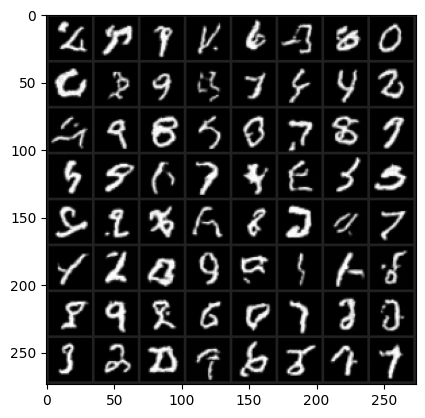

<Figure size 640x480 with 0 Axes>

In [24]:
s = SFromEta(eta, interpolant.a)

sde_flow = SDEIntegrator(b=b, s=s, eps=torch.tensor(0.01), n_save=4, start_end=(0.0001, 0.999), n_step=10**5).to(device)
pflow = PFlowIntegrator(b=b,  method='dopri5', interpolant=interpolant, n_step=3)
bs = 64
with torch.no_grad():
    x0_tests  = torch.randn(bs,1, 32, 32).to(device)
    print(x0_tests.is_cuda)
    # ([bs, dim], [bs]
    xfs_sde   = sde_flow.rollout_forward(x0_tests, 'heun') # [n_save x bs x dim]
    xf_sde    = grab(xfs_sde[-1].squeeze())
    xf_sde = xf_sde.reshape(64,1,32,32)
    print(xf_sde.shape)

imshow(torchvision.utils.make_grid(torch.tensor(xf_sde)))
xf_sde = xf_sde.transpose(0, 2, 3, 1)




# Ajuster l'espacement entre les subplots pour une meilleure présentation
plt.tight_layout()
plt.show()